<center>
<h1>Mustererkennung und Machine Learning</h1>

<h3> Wintersemester 2017/2018, 9th Exercise Sheet</h3>
<h4>Konstantin Jaehne, Luis Herrmann; Dozent: Raúl Rojas</h4>

<hr style='height:1px'>
</center>

# Exercise 1

As usual, we read in the digit dataset fron the respective files:

In [70]:
%matplotlib inline
import sys
import numpy as np
import numpy.random as nprd
import random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display, HTML

def readfile(filename):
    """Opens file with given filename and reads in data line after line into a numpy array"""
    data = [[] for i in range(10)]
    f = open(filename)
    for line in f:
        ls = line.split(' ')
        digit = int(float(ls[0]))
        sample = np.array([float(val) for val in ls[1:257]])
        data[digit].append(sample)
    f.close()
    return(list(map(lambda x: np.vstack(x), data)))
    
def visualize(data, i, shape):
    """
    For a list of numpy arrays with greyscale values, visualizes the greyscale data 
    creating a greyscale plot of the reshaped 16x16 numpy array
    """
    plt.gray()
    plt.imshow(data[i].reshape(shape))
    
train = readfile('../zip.train')
test = readfile('../zip.test')

Again, we visualize a sample feature vector from the data to make sure the data makes sense.

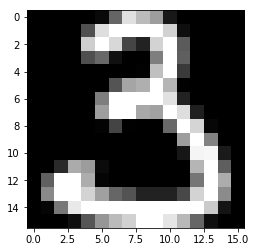

In [2]:
visualize(train[3], 0, [16,16])

We now implement a neurol network class, which allows for training using forward-feeding and backpropagation and classification

In [76]:
class NeuronNetwork:
    def __init__(self, data = None, 
                 labels=None, 
                 itlimit=2000, 
                 tol=1e-19, 
                 pcount=None, 
                 lcount=1, 
                 interactive=False,
                 ret = True,
                 beta=1e-3):
        """
        data (optional):
            Type: List/Tuple
            A list/tuple (d1,..., dm), where di is a matrix in which each row is a feature vector assigned to class i.
        labels (optinal):
            Type: List/Tuple
            A list/tuple (i1,..., im) of m printable identifiers associated with each class.
        itlimit (optional):
            Type: Integer
            Maximum number of iterations, before training is forcefully terminated.
        tol (optional):
            Type: Float
            Minimum rate of improvement that is acceptable. If improvement drops below tolerance, stop descent.
        pcount (optional):
            Type: Integer
            Number of perceptrons to be used in each hidden layer.
        lcount (optional):
            Type: Integer
            Number of hidden layers to be used.
        interactive (optional):
            Type: Boolean
            If True will plot error rate in real time.
        ret (optional):
            Type: Boolean
            If True will return a list l where l[i] is the error of the i-th iteration
        beta (optional):
            Type: Float
            The learning rate used in the gradient descent.
        """
        self.labels = labels
        if(not(data is None)):
            self.train(data, itlimit, tol, pcount, lcount, interactive, ret, beta)
        
    def train(self, data, itlimit=1000, tol=1e-19, pcount=None, lcount=1, interactive=False, ret=True, beta=1e-3):
        if(self.labels is None):
            self.labels = range(len(data))
        x = np.vstack(data)
        #Normalize data
        self.mean = np.mean(x, axis=0)[np.newaxis,:] 
        self.variance = np.var(x, axis=0)[np.newaxis,:]
        self.variance[np.where(self.variance == 0)] = 1
        x = self.normalize(x)
        #Create label vector
        n = x.shape[1]
        m = len(self.labels)
        self.y = np.zeros([x.shape[0], m])
        comp = np.zeros(x.shape[0])
        low = 0
        for i in range(len(data)):
            high = low + data[i].shape[0]
            self.y[low:high,i] = 1
            comp[low:high] = i
            low = high
        
        o = np.hstack([x, np.repeat(1, x.shape[0])[:,np.newaxis]])
        #Initialize random hidden layer and output layer weights:
        if(pcount is None):
            pcount = x.shape[0]
        self.W = [nprd.rand(n+1, pcount)] + [nprd.rand(pcount+1, pcount) for i in range(lcount-1)] + [nprd.rand(pcount+1, m)]
        #Initialize iteration parameters:
        t = 0
        #Initialize interactive plot
        if(interactive):
            plt.ion()
            fig = plt.figure()
            ax = fig.add_subplot(111)
        err = []

        while(t < itlimit):
            #Calculate hidden-layer and output-layer output:
            ol = self.feedforward(o)
            #Calculate backprop errors of both layers:
            dl =[ol[-1] * (1 - ol[-1]) * (self.y - ol[-1])]
            dl.insert(0, ol[-2] * (1 - ol[-2]) * np.dot(dl[0], np.transpose(self.W[-1])))
            for i in reversed(range(len(ol)-2)):
                d = ol[i] * (1 - ol[i]) * np.dot(dl[0][:,:-1], np.transpose(self.W[i+1]))
                dl.insert(0, d)
            #Using backprop errors, calculate new weights
            dW = [np.dot(np.transpose(o), dl[0][:,:-1])]
            for i in range(1, len(ol)-1):
                dWi = np.dot(np.transpose(ol[i-1]), dl[i][:,:-1])
                dW.append(dWi)
            dW.append(np.dot(np.transpose(ol[-2]), dl[-1]))

            #If the error improvement drops below a certain tolerance, quit descent
            #if(totimp < tol):
            #    break
            for i in range(len(self.W)):
                self.W[i] += beta * dW[i]
            t += 1
            
            err.append(1 - np.sum(comp == np.argmax(ol[-1], axis=1)) / x.shape[0])
            #Update interactive plot
            if(interactive):
                ax.plot(range(1,t+1), err, 'r-', antialiased=True)
                fig.canvas.draw()
            
            sys.stdout.write(str(t) + ' iterations, error rate ' + str(err[t-1]) + ', stepsize %.3e' % beta + '\r')
        print('\nDone!')
        if(interactive):
            plt.ioff()
        if(ret):
            return(err)
            
    def normalize(self, data):
        """Normalizes the data to allow for faster convergence of the gradient ascent"""
        return((data - self.mean) / self.variance)
            
    def feedforward(self, o, W=None):
        """Feed-forward given input o and weight matrices W1 and W2."""
        if(W is None):
            W = self.W
        o1 = self.sigmoid(np.dot(o, W[0]))
        ol = [np.hstack([o1, np.repeat(1, o1.shape[0])[:,np.newaxis]])]
        for i in range(1, len(W)-1):
            oi = self.sigmoid(np.dot(ol[-1], W[i]))
            ol.append(np.hstack([oi, np.repeat(1, oi.shape[0])[:,np.newaxis]]))
        ol.append(self.sigmoid(np.dot(ol[-1], W[-1])))
        return(ol)
        
    def classify(self, data):
        """Classifies a set of data vectors, returning a list of the labels assigned"""
        o = np.hstack([self.normalize(data), np.repeat(1, data.shape[0])[:,np.newaxis]])
        ol = self.feedforward(o)
        return([self.labels[x] for x in np.argmax(ol[-1], axis=1)])
        
    def sigmoid(self, x):
        """The sigmoidal functinon as defined by the numerically more stable tanh"""
        return(1/2 * (1 + np.tanh(1/2 * x)))

We then perform training on the digit dataset for different layer depths and perceptron counts and plot the classification error for the training data at every iteration step:

In [100]:
plcounts = [(5,1), (5,2), (10,1), (10,2), (20,1), (40,1)]
NNC = []
err = []
for (pcount,lcount) in plcounts:
    %time NNCi = NeuronNetwork()
    err.append(NNCi.train(train, pcount=pcount, lcount=lcount, itlimit=2000, beta=1e-3))
    NNC.append(NNCi)

Wall time: 0 ns
2000 iterations, error rate 0.0799615964888, stepsize 1.000e-03
Done!
Wall time: 0 ns
2000 iterations, error rate 0.281580030174, stepsize 1.000e-03
Done!
Wall time: 0 ns
2000 iterations, error rate 0.0593882869291, stepsize 1.000e-03
Done!
Wall time: 0 ns
2000 iterations, error rate 0.159237415992, stepsize 1.000e-03
Done!
Wall time: 0 ns
2000 iterations, error rate 0.0733781374297, stepsize 1.000e-03
Done!
Wall time: 0 ns
2000 iterations, error rate 0.063365793444, stepsize 1.000e-033
Done!


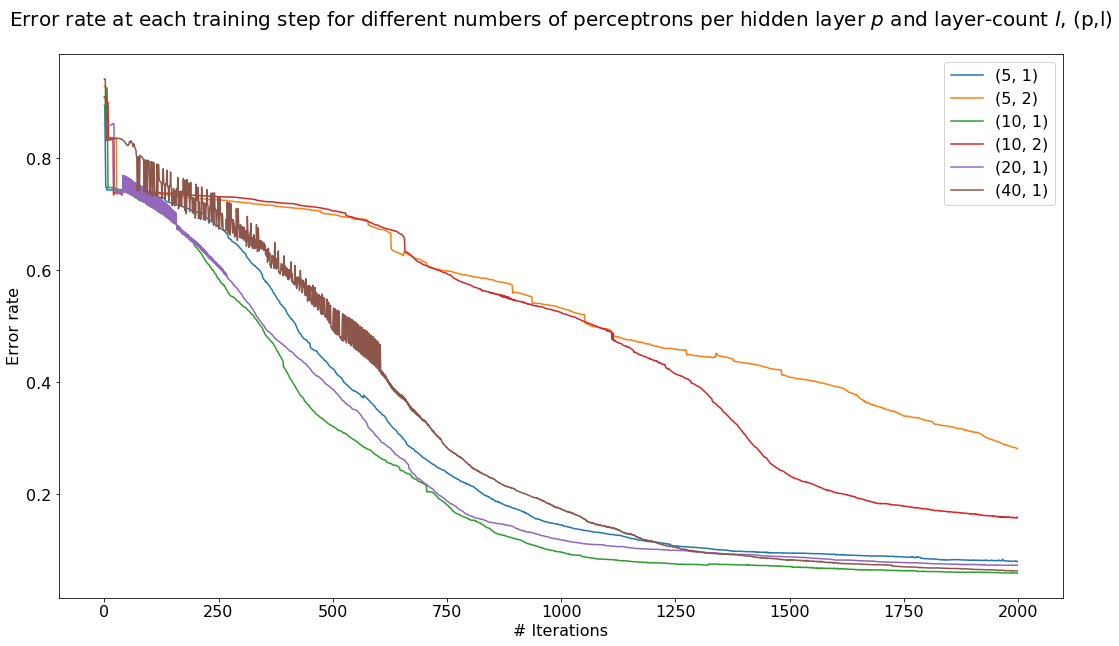

In [101]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize = (18, 10))
for i in range(len(NNC)):
    plt.title('Error rate at each training step for different numbers of perceptrons per hidden layer $p$ and layer-count $l$, (p,l)\n',
             fontsize=20)
    plt.xlabel('# Iterations')
    plt.ylabel('Error rate')
    plt.plot(range(len(err[i])), err[i], '-', antialiased=True, label=str(plcounts[i]))
plt.legend()

We also take a look at the confusion matrices for the classification of the entire available data (train + test):

In [91]:
from IPython.display import display, HTML

def runtest(C):
    confusionMat = np.zeros([10, 10], dtype=int)
    for i in range(10):
        data = np.vstack([train[i], test[i]])
        result = C.classify(data)
        for j in range(len(result)):
            confusionMat[i,result[j]] += 1
    print('-The confusion matrix is given by:')
    html = pd.DataFrame(confusionMat,index=C.labels, columns=C.labels).to_html()
    display(HTML(html))
    print('-The error rate is: ' + str(1-sum(np.diag(confusionMat))/np.sum(confusionMat)) + '\n')

In [94]:
for i in range(len(NNC)):
    print('(p,l) = ' + str(plcounts[i]) + ":\n")
    runtest(NNC[i])

(p,l) = (5, 1):

-The confusion matrix is given by:


,0,1,2,3,4,5,6,7,8,9
0,1464,0,10,57,10,3,6,0,3,0
1,0,1242,4,1,2,0,9,7,1,3
2,3,4,830,39,10,1,21,7,13,1
3,2,0,18,742,2,41,2,6,8,3
4,12,15,37,2,685,23,15,23,11,29
5,14,0,19,77,21,534,30,8,5,8
6,30,12,19,4,11,7,748,2,1,0
7,0,1,2,8,14,13,4,734,1,15
8,12,3,29,69,7,8,4,12,536,28
9,0,1,3,3,27,21,0,25,11,730


-The error rate is: 0.113250161325

(p,l) = (5, 2):

-The confusion matrix is given by:


,0,1,2,3,4,5,6,7,8,9
0,1504,0,9,19,0,3,15,0,3,0
1,0,1237,3,2,0,0,9,0,1,17
2,6,6,620,137,1,4,12,22,89,32
3,8,0,76,668,0,0,1,0,65,6
4,16,100,126,1,61,1,11,117,3,416
5,33,0,138,337,0,8,13,5,176,6
6,67,6,20,9,1,0,726,0,2,3
7,1,2,136,2,0,1,0,322,3,325
8,11,2,44,111,1,4,13,10,484,28
9,2,4,52,4,0,0,0,121,5,633


-The error rate is: 0.326414282641

(p,l) = (10, 1):

-The confusion matrix is given by:


,0,1,2,3,4,5,6,7,8,9
0,1507,0,11,3,2,4,23,2,1,0
1,0,1235,4,2,6,2,13,4,2,1
2,13,2,833,17,22,3,15,7,15,2
3,11,1,15,777,4,8,0,1,6,1
4,6,6,12,3,771,4,16,4,11,19
5,22,4,10,41,10,599,11,5,12,2
6,2,1,13,1,3,12,798,0,4,0
7,5,2,2,6,7,1,0,747,2,20
8,16,7,21,21,16,26,12,5,582,2
9,2,2,0,9,17,3,0,21,1,766


-The error rate is: 0.0734566573457

(p,l) = (10, 2):

-The confusion matrix is given by:


,0,1,2,3,4,5,6,7,8,9
0,1503,0,3,14,2,10,20,0,1,0
1,0,1233,1,0,15,3,8,1,2,6
2,10,5,758,62,12,39,17,3,23,0
3,14,0,54,703,1,21,3,13,14,1
4,13,33,20,9,630,18,11,25,3,90
5,38,1,77,91,10,393,35,9,56,6
6,7,4,8,3,6,13,788,0,5,0
7,0,0,7,4,17,1,0,737,1,25
8,7,2,21,75,22,26,14,17,518,6
9,2,0,6,8,65,0,0,39,1,700


-The error rate is: 0.143579264358

(p,l) = (20, 1):

-The confusion matrix is given by:


,0,1,2,3,4,5,6,7,8,9
0,1511,1,2,17,2,4,7,0,7,2
1,0,1241,4,2,7,2,7,2,2,2
2,14,2,825,20,14,9,10,20,14,1
3,11,1,11,750,7,20,1,11,10,2
4,20,18,13,25,713,6,5,14,23,15
5,29,3,5,55,5,591,6,7,12,3
6,15,5,5,1,9,14,779,0,6,0
7,1,2,3,30,9,7,0,710,6,24
8,16,3,1,25,22,17,4,16,601,3
9,5,4,0,19,31,4,1,38,11,708


-The error rate is: 0.0934609593461

(p,l) = (40, 1):

-The confusion matrix is given by:


,0,1,2,3,4,5,6,7,8,9
0,1498,1,2,30,1,3,13,2,2,1
1,0,1247,1,0,4,6,3,5,0,3
2,17,11,780,35,14,12,5,29,24,2
3,8,1,22,754,1,17,1,13,5,2
4,20,8,16,1,750,34,7,2,1,13
5,19,1,8,55,7,599,18,2,4,3
6,16,13,10,2,8,18,763,0,3,1
7,4,4,13,72,5,20,0,649,1,24
8,8,18,24,25,8,48,2,10,562,3
9,1,3,4,7,17,6,0,13,4,766


-The error rate is: 0.100021510002



Interestingly, the best result within the given number of iterations (2000) is obtained for 10 perceptrons and 1 layer. For higher numbers of layers or of perceptrons, the convergence of the algorithm is slower, which is logical, because more weights have to be calculated in each step. On the other hand, the error curve for $(p, l) = (5, 1)$ typically reaches saturation earlier than for all other error curves for higher perceptron numbers. This could indicate that this number of perceptrons is too low, such that no higher classification rates can be achieved with that given number of perceptrons.

Another remarkable fact is that for higher iteration numbers, the number of wrong classifications features high fluctuations. This instability may stem from overfitting and could suggest that the number of perceptron is innecessarily high.

# Exercise 2

Just as in exercise 7, we will try to fit the train the neural network to predict the result of logical functions. As we will see in a minute, this time we wil be able to train the network even for the XOR function obtaining a final error rate of 0.

In [4]:
anddata = np.array([[1,1]]), np.array([[0,0],[0,1],[1,0]])
ordata = np.array([[1,1],[0,1],[1,0]]), np.array([[0,0]])
xordata = np.array([[0,1],[1,0]]), np.array([[0,0],[1,1]])

In [88]:
Cand, Cor, Cxor = NeuronNetwork(), NeuronNetwork(), NeuronNetwork()
anderr = Cand.train(anddata, itlimit=1000, pcount=4, beta=1e-1)
orerr = Cor.train(ordata, itlimit=1000, pcount=4, beta=1e-1)
xorerr = Cxor.train(xordata, itlimit=1000, pcount=4, beta=1e-1)
err = (anderr, orerr, xorerr)

1000 iterations, error rate 0.0, stepsize 1.000e-01
Done!


1000 iterations, error rate 0.0, stepsize 1.000e-01
Done!
1000 iterations, error rate 0.0, stepsize 1.000e-01
Done!


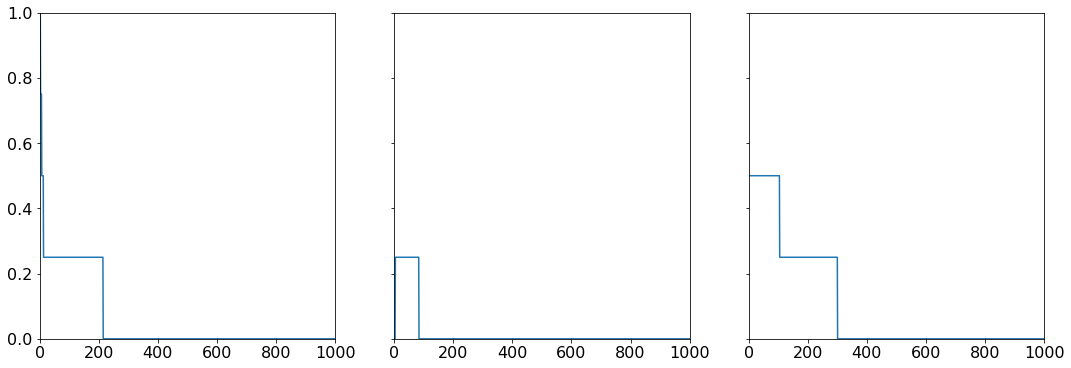

In [89]:
fig, subplots = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
for i in range(len(subplots)):
    subplots[i].set_xlim(0,len(err[i]))
    subplots[i].set_ylim(0,1)
    subplots[i].plot(range(1,len(err[i])+1), err[i])